Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters Found: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Feature importances saved to best_rf_features.csv
Accuracy: 0.997867803837953
F1 Score: 0.9934065934065934
Precision: 0.9912280701754386
Recall: 0.9955947136563876

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1180
           1       0.99      1.00      0.99       227

    accuracy                           1.00      1407
   macro avg       1.00      1.00      1.00      1407
weighted avg       1.00      1.00      1.00      1407



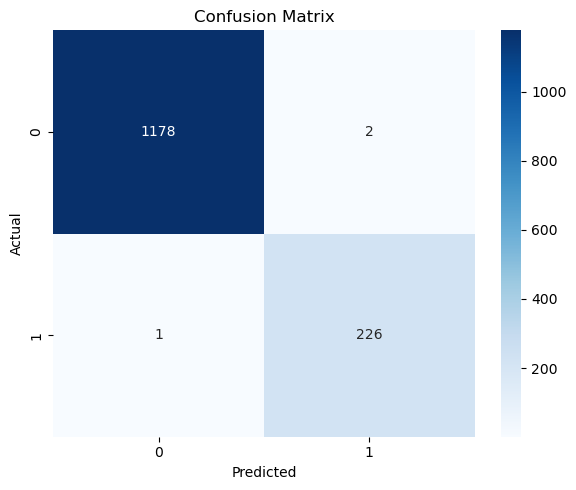

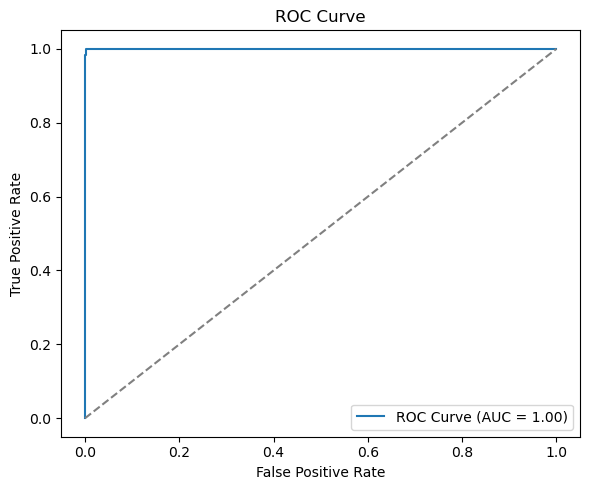

In [ ]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import ml_helpers as hlp


def tune_random_forest(X_train, y_train):
    """Tune RandomForestClassifier with error handling."""
    hlp.validate_training_data(X_train, y_train)

    param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']

    }

    try:
        rf = RandomForestClassifier(random_state=42)
        grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)
    except Exception as e:
        raise RuntimeError(f"Grid search failed: {e}")

    print("Best Parameters Found:", grid.best_params_)
    return grid.best_estimator_, grid.best_params_

def save_feature_importances(model, feature_names, save_path="best_rf_features.csv"):
    importances = model.feature_importances_
    feat_imp = pd.DataFrame({ 'Feature': feature_names, 'Importance': importances })
    feat_imp = feat_imp.sort_values(by='Importance', ascending=False)
    feat_imp.to_csv(save_path, index=False)
    print(f"Feature importances saved to {save_path}")
    return feat_imp


def get_top_features(feat_imp_df, top_n=6):
    """Get top N features based on importance."""
    return feat_imp_df.head(top_n)['Feature'].tolist()


def train_with_top_features(X_train, y_train, top_features, best_params):
    """Train RandomForest with top N features and best parameters."""
    model = RandomForestClassifier(**best_params, random_state=42)
    model.fit(X_train[top_features], y_train)
    return model

if __name__ == "__main__":
    path = "C:\\Users\\Jinane Rachid\\Desktop\\cleaned_nasa_data1.csv"
    feat_out_path = "best_rf_features.csv"
    # Load & split
    X, y = hlp.load_data(path)
    X_train, X_test, y_train, y_test = hlp.split_data(X, y)

    # Tune RF and capture both model & params
    best_rf, best_params = tune_random_forest(X_train, y_train)

    # Save importances and grab the DataFrame
    feat_imp = save_feature_importances(best_rf, X.columns, feat_out_path)

    # Get top features from that DataFrame
    top_features = get_top_features(feat_imp, top_n=6)

    # Train final model on top features
    new_rf = train_with_top_features(X_train, y_train, top_features, best_params)

    #create df includes top features
    X_test_top = X_test[top_features]
    # Evaluate
    hlp.evaluate_model_basic(new_rf, X_test_top, y_test)
    hlp.evaluate_model_with_proba(new_rf, X_test_top, y_test)

    # save model
    joblib.dump(new_rf, "final_rf_model.joblib")
